In [1]:
import numpy as np
import matplotlib.pyplot as plt

from spikingDataUtilities import loadMATData, spikeTimes, firingRate, restrict

In [2]:
data_dir = '/Users/giacomopreti/Desktop/BH2026/raw'
data = loadMATData(f"{data_dir}/session1.mat")

data['protocol_names']

['sleep1', 'task1', 'sleep2', 'task2', 'sleep3']

In [3]:
stacked = []
protocol_number = 0
protocol_name = data['protocol_names'][protocol_number]
bin_size = 0.05
for spike_type in ['spikes_hpc', 'spikes_nr', 'spikes_pfc']:
    sleep_data = restrict(data[spike_type], [data['protocol_times'][protocol_number]])
    sleep_firing_rate = firingRate(sleep_data, bin_size=bin_size)
    sleep_firing_rate = np.delete(sleep_firing_rate, 0, axis=1) # Remove time zero column
    stacked.append(sleep_firing_rate)

stacked_firing_rates = np.hstack(stacked)
stacked_firing_rates = stacked_firing_rates[int(1454/0.05):,:]

Text(0.5, 1.0, 'Firing rate of a neuron for sleep1')

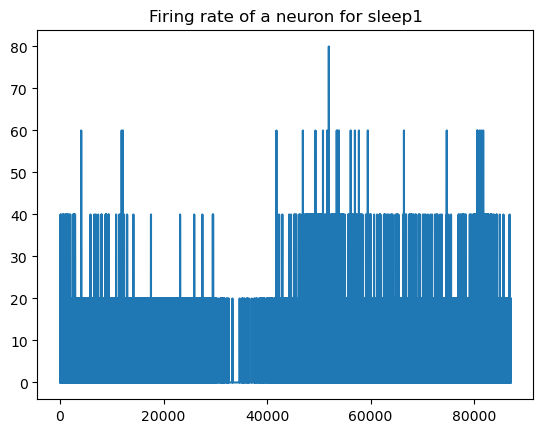

In [4]:
plt.plot(stacked_firing_rates[int(1454/0.05):,1])
plt.title(f'Firing rate of a neuron for {protocol_name}')

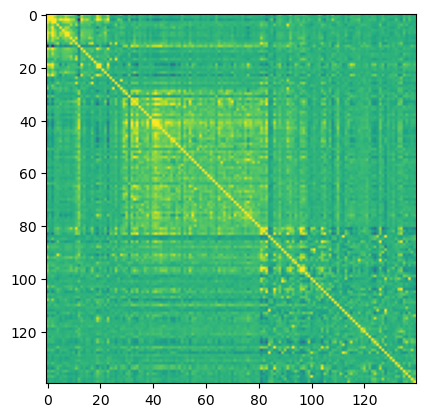

In [5]:
fc = np.corrcoef(stacked_firing_rates.T)
plt.imshow(fc, vmax=0.1)


In [6]:
stacked_firing_rates.shape

(116188, 140)

In [27]:
import importlib
import giaco_utils
importlib.reload(giaco_utils)
from giaco_utils import compute_fcd, compute_time_window_fc_t
window_length = 1000
overlap=500
fcd = compute_fcd(stacked_firing_rates, window_length=window_length, overlap=overlap)

/opt/anaconda3/envs/desuenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/desuenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'FCD matrix of sleep1 for window_length=1000, overlap=500')

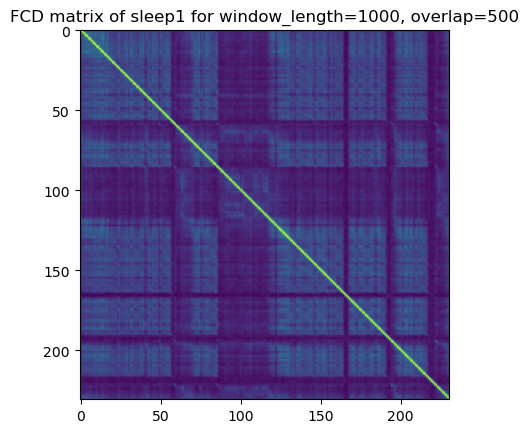

In [28]:
plt.imshow(fcd)
plt.title(f'FCD matrix of {protocol_name} for window_length={window_length}, overlap={overlap}')

In [36]:
FC_t = compute_time_window_fc_t(stacked_firing_rates, window_length=1000, overlap=500)

/opt/anaconda3/envs/desuenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/desuenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [37]:
importlib.reload(giaco_utils)
from giaco_utils import silhouette_for_kmeans, run_kmeans

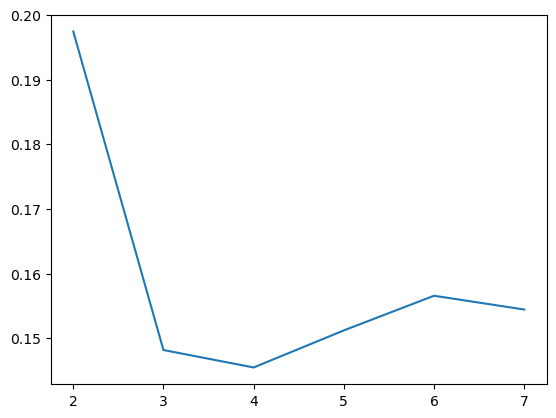

In [38]:
silhouette_for_kmeans(FC_t.T)

In [39]:
X_pca, labels = run_kmeans(FC_t.T, 3)

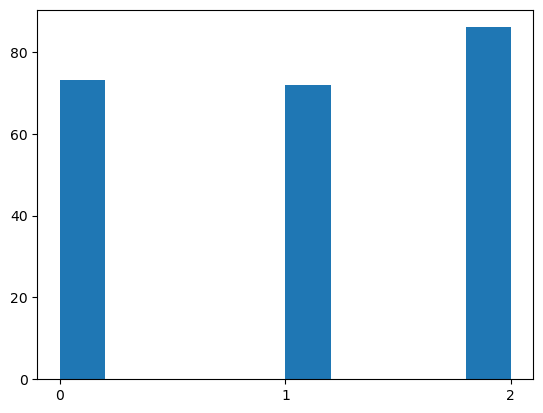

In [40]:
plt.hist(labels)
lab = len(np.unique(labels))
plt.xticks(range(lab), range(lab));

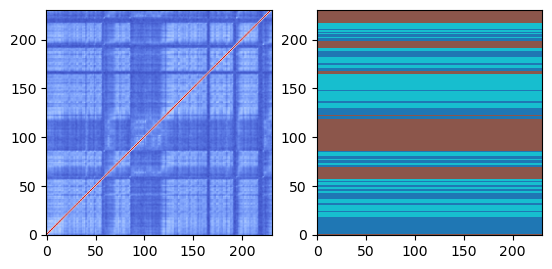

In [41]:
import plotting_utils
importlib.reload(plotting_utils)
from plotting_utils import plot_fcd_with_states, plot_clustered_fc

plot_fcd_with_states(labels, fcd)

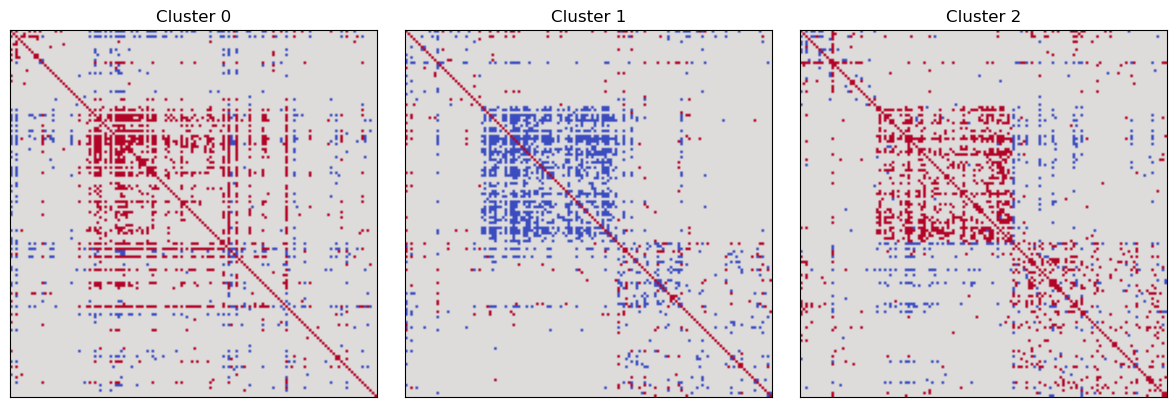

In [42]:
plot_clustered_fc(FC_t, 140, labels)

In [43]:
from giaco_utils import get_sleep_labels_for_fcd
protocol_states = get_sleep_labels_for_fcd(window_length, overlap, bin_size, FC_t, data)

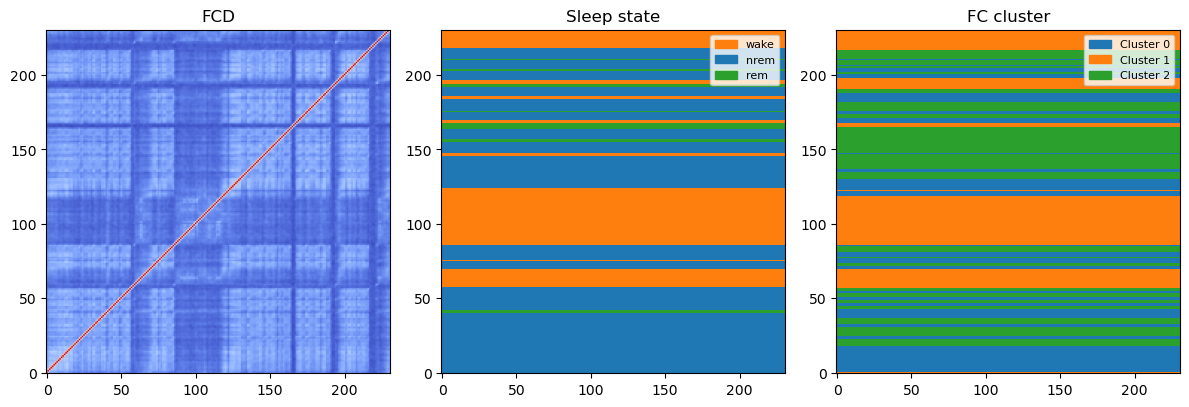

In [48]:
import plotting_utils
importlib.reload(plotting_utils)
from plotting_utils import plot_fcd_with_statesand_clusters
plot_fcd_with_statesand_clusters(fcd, protocol_states, labels)

In [ ]:
window_step = window_length - overlap
fs = 1/bin_size  # example: 1 kHz
n_windows = FC_t.shape[1]
window_starts = np.arange(n_windows) * window_step / fs
window_ends   = window_starts + window_length / fs

sleep_start = 1454

window_starts_abs = window_starts + sleep_start
window_ends_abs   = window_ends   + sleep_start

window_times = np.c_[window_starts_abs, window_ends_abs]

def overlap_duration(win, interval):
    start = max(win[0], interval[0])
    end   = min(win[1], interval[1])
    return max(0.0, end - start)

def assign_state(window, wake, rem, nrem):
    overlaps = {
        "wake": sum(overlap_duration(window, i) for i in wake),
        "rem":  sum(overlap_duration(window, i) for i in rem),
        "nrem": sum(overlap_duration(window, i) for i in nrem),
    }
    return max(overlaps, key=overlaps.get)

states = []

for w in window_times:
    states.append(
        assign_state(
            w,
            data["wake"],
            data["rem"],
            data["nrem"]
        )
    )

states = np.array(states)
states.shape == (n_windows,)




True

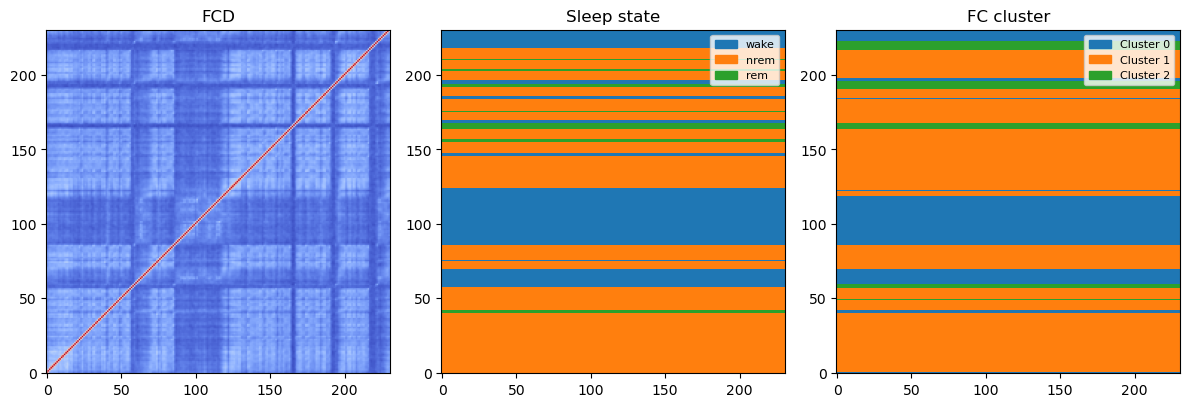

In [ ]:
import matplotlib.patches as mpatches

state_to_int = {s: i for i, s in enumerate(['wake', 'nrem', 'rem'])}

    state_int = np.array([state_to_int[s] for s in protocol_states])
    state_img = np.tile(state_int[:, None], (1, len(state_int)))
    state_img.shape == (len(state_int), len(state_int))

    label_img = np.tile(cluster_labels[:, None], (1, len(cluster_labels)))
    label_img.shape == (len(cluster_labels), len(cluster_labels))

sleep_handles = [
    mpatches.Patch(color=cmap(state_to_int[s]), label=s)
    for s in ['wake', 'nrem', 'rem']
]

cluster_labels = np.unique(labels)
cluster_handles = [
    mpatches.Patch(color=cmap(i), label=f'Cluster {i}')
    for i in cluster_labels
]

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(fcd, cmap="coolwarm", origin="lower")
plt.title("FCD")

plt.subplot(132)
plt.imshow(
    state_img,
    cmap=cmap,
    norm=norm,
    origin="lower",
    interpolation="nearest"
)
plt.title("Sleep state")
plt.legend(handles=sleep_handles, loc="upper right", fontsize=8)

plt.subplot(133)
plt.imshow(
    label_img,
    cmap=cmap,
    norm=norm,
    origin="lower",
    interpolation="nearest"
)
plt.title("FC cluster")
plt.legend(handles=cluster_handles, loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()


In [375]:
spikes_hpc = spikeTimes(data['spikes_hpc'], data['protocol_times'])
spikes_nr = spikeTimes(data['spikes_nr'], data['protocol_times'])
spikes_pfc = spikeTimes(data['spikes_pfc'], data['protocol_times'])

In [378]:
spike_times = spikes_hpc[1]

In [383]:
spike_times = [np.asarray(s, dtype=float) for s in spike_times]

In [407]:
importlib.reload(giaco_utils)
from giaco_utils import get_sttc_matrix, sttc

delta_t = 0.02   # 10 ms
T = 10000

STTC = get_sttc_matrix(spike_times,delta_t, T)


In [434]:
np.max(spike_times[0])

np.float64(10000.3869)

In [435]:
from joblib import Parallel, delayed

def spikes_in_window(spike_times, start, end):
    """
    Get spike times of each neuron within [start, end)
    """
    return [s[(s >= start) & (s < end)] - start for s in spike_times]

def dynamic_sttc(spike_times, delta_t, T, window_length, step_size, n_jobs=8):
    """
    Compute time-resolved STTC matrix for all sliding windows.
    
    Returns:
        sttc_dyn: np.array, shape (n_windows, n_neurons, n_neurons)
        window_starts: list of window start times
    """
    n_neurons = len(spike_times)
    window_starts = np.arange(np.min(spike_times[0]), T - window_length + 1, step_size)
    n_windows = len(window_starts)
    
    sttc_dyn = np.zeros((n_windows, n_neurons, n_neurons))
    
    for w, start in enumerate(window_starts):
        end = start + window_length
        window_spikes = spikes_in_window(spike_times, start, end)
        
        # Compute STTC for this window
        pairs = [(i, j) for i in range(n_neurons) for j in range(i+1, n_neurons)]
        results = Parallel(n_jobs=n_jobs)(
            delayed(sttc)(window_spikes[i], window_spikes[j], delta_t, window_length)
            for i, j in pairs
        )
        
        # Fill symmetric matrix
        k = 0
        for i in range(n_neurons):
            for j in range(i+1, n_neurons):
                sttc_dyn[w, i, j] = results[k]
                sttc_dyn[w, j, i] = results[k]
                k += 1
                
    return sttc_dyn, window_starts



In [411]:
len(spike_times[1])

1725

In [520]:
sttc_dyn, _ = dynamic_sttc(spike_times, 0.1, 10000, 100, 15)

In [521]:
corr = []
for matri in sttc_dyn:
    for x in sttc_dyn:
        corr.append(np.corrcoef(matri.flatten(), x.flatten())[0][1])

corr = np.array(corr).reshape(len(sttc_dyn), len(sttc_dyn))

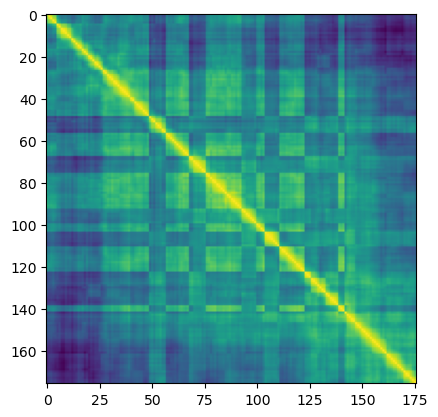

In [522]:
plt.imshow(corr)

In [523]:
fcd_metr = []

for i in range(sttc_dyn.shape[0]):
    FC = sttc_dyn[i]                # shape (n_neurons, n_neurons)
    Isupdiag = np.triu_indices(FC.shape[0], k=1)  # k=1 skips the diagonal
    fcd_metr.append(FC[Isupdiag])

fcd_metr = np.array(fcd_metr)       # shape (n_windows, n_edges)


In [524]:
fcd_metr.shape

(176, 406)

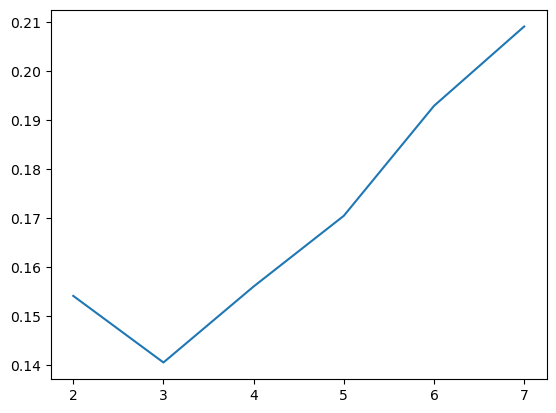

In [525]:
silhouette_for_kmeans(fcd_metr)

In [526]:
X_pca, labels = run_kmeans(fcd_metr, 6)

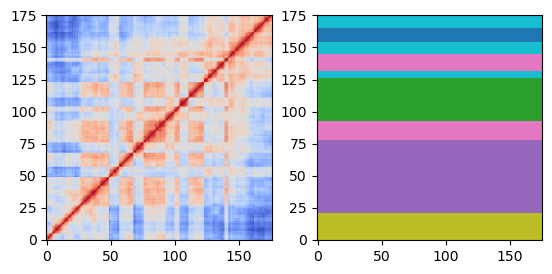

In [527]:
label_img = np.tile(labels[:, None], (1, len(labels)))
label_img.shape == (len(labels), len(labels))


# Base layer: FCD
plt.subplot(121)
plt.imshow(corr, cmap="coolwarm", origin="lower")
plt.subplot(122)
# Overlay: labels
plt.imshow(label_img, cmap="tab10", origin="lower", alpha=1,
           interpolation="nearest")